<a href="https://colab.research.google.com/github/hkjoh1103/CNMH2022_psychiatric_NLP_classification/blob/main/BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/Colab/CNMH/Main

/content/drive/MyDrive/Colab/CNMH/Main


In [ ]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.3 MB 5.1 MB/s 
     |████████████████████████████████| 163 kB 93.4 MB/s 
     |████████████████████████████████| 7.6 MB 47.6 MB/s 


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.model_selection import train_test_split
import pandas as pd
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Colab/CNMH/Main/datasets/data_v2.refine.train.tsv', sep='\t', header=None)
train_df, valid_df = train_test_split(data, test_size=0.2, random_state=221023)
test_df = pd.read_csv('/content/drive/MyDrive/Colab/CNMH/Main/datasets/data_v2.refine.test.tsv', sep='\t', header=None)

In [ ]:
class Datasets(Dataset):
    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        text = self.df.iloc[idx, 1][:300]
        label = self.df.iloc[idx, 0] - 1
        return text, label

In [ ]:
train_dataset = Datasets(train_df)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=0)

valid_dataset = Datasets(valid_df)
valid_loader = DataLoader(valid_dataset, batch_size=8, shuffle=True, num_workers=0)

test_dataset = Datasets(test_df)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=True, num_workers=0)

In [ ]:
test_df[0].value_counts()

1    117
3     57
2     33
5     14
4      7
6      5
Name: 0, dtype: int64

In [ ]:
dataiter = iter(test_loader)
text, label = dataiter.next()

In [ ]:
tokenizer = BertTokenizer.from_pretrained('beomi/kcbert-base')
model = BertForSequenceClassification.from_pretrained('beomi/kcbert-base', num_labels=6)
model.to(device)

Downloading:   0%|          | 0.00/250k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/619 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Some weights of the model checkpoint at beomi/kcbert-base were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initiali

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30000, 768, padding_idx=0)
      (position_embeddings): Embedding(300, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
def save_checkpoint(save_path, model, valid_loss):
    if save_path == None:
      print("Invalid save path")
      return    
    state_dict = {'model_state_dict': model.state_dict(),
                  'valid_loss': valid_loss}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')

def load_checkpoint(load_path, model):    
    if load_path==None:
      print("Invalid load path")
      return    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    model.load_state_dict(state_dict['model_state_dict'])
    return state_dict['valid_loss']

def save_metrics(save_path, accuracy, train_loss_list, valid_loss_list, global_steps_list):
    if save_path == None:
      print("Invalid save path")
      return    
    state_dict = {'accuracy': accuracy,
                  'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'global_steps_list': global_steps_list}    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')

def load_metrics(load_path):
    if load_path==None:
      print("Invalid load path")
      return    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')    
    return state_dict['accuracy'], state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']

In [ ]:
def train(model,
          optimizer,
          criterion = nn.CrossEntropyLoss(),
          num_epochs = 50,
          eval_every = len(train_loader) // 1,
          best_valid_loss = float("Inf")):
    
    total_correct = 0.0
    total_len = 0.0
    running_loss = 0.0
    valid_running_loss = 0.0
    global_step = 0
    train_loss_list = []
    valid_loss_list = []
    global_steps_list = []
    valid_accuracy_list = []
    valid_correct = 0.0

    model.train()
    for epoch in range(num_epochs):
        for text, label in train_loader:
            optimizer.zero_grad()        
            encoded_list = [tokenizer.encode(t, add_special_tokens=True, max_length=300) for t in text]
            padded_list =  [e + [0] * (300-len(e)) for e in encoded_list]
        
            sample = torch.tensor(padded_list)
            sample, label = sample.to(device), label.to(device)
            labels = label
            outputs = model(sample, labels=labels)
            
            loss, logits = outputs.loss, outputs.logits

            pred = torch.argmax(F.softmax(logits), dim=1)
            correct = pred.eq(labels)
            total_correct += correct.sum().item()
            total_len += len(labels)
            running_loss += loss.item()
            loss.backward()
            optimizer.step()        
            global_step += 1

            if global_step % eval_every == 0:
                model.eval()
                with torch.no_grad():                    
                    for text, label in valid_loader:
                        encoded_list = [tokenizer.encode(t, add_special_tokens=True, max_length=300) for t in text]
                        padded_list =  [e + [0] * (300-len(e)) for e in encoded_list]        
                        sample = torch.tensor(padded_list)
                        sample, label = sample.to(device), label.to(device)
                        labels = label
                        outputs = model(sample, labels=labels)
                        loss, logits = outputs.loss, outputs.logits                      
                        valid_running_loss += loss.item()

                        pred_val = torch.argmax(F.softmax(logits), dim=1)
                        valid_correct += pred_val.eq(labels).sum().item()

                average_train_loss = running_loss / eval_every
                average_valid_loss = valid_running_loss / len(valid_loader)
                train_loss_list.append(average_train_loss)
                valid_loss_list.append(average_valid_loss)
                global_steps_list.append(global_step)
                valid_accuracy = valid_correct / (8*len(valid_loader)) * 100
                valid_accuracy_list.append(valid_accuracy)

                running_loss = 0.0                
                valid_running_loss = 0.0
                valid_correct = 0.0
                model.train()

                print('Epoch [{}/{}], Step [{}/{}], Accuracy: {:.2f}%, Train Loss: {:.4f}, Valid Loss: {:.4f}'
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(train_loader),
                              valid_accuracy, average_train_loss, average_valid_loss))
                
                if best_valid_loss > average_valid_loss:
                    best_valid_loss = average_valid_loss
                    save_checkpoint('./checkpoint/model.pt', model, best_valid_loss)
                    save_metrics('./results/metrics.pt', valid_accuracy, train_loss_list, valid_loss_list, global_steps_list)
    
    save_metrics('./results/metrics.pt',valid_accuracy_list, train_loss_list, valid_loss_list, global_steps_list)
    print('훈련 종료!')

In [ ]:
optimizer = optim.Adam(model.parameters(), lr = 2e-5)
train(model=model, optimizer=optimizer)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


KeyboardInterrupt: ignored

Model loaded from <== ./results/metrics.pt


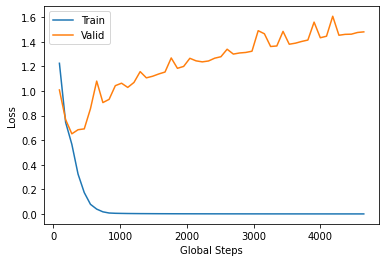

In [ ]:
valid_accuracy_list, train_loss_list, valid_loss_list, global_steps_list = load_metrics('./results/metrics.pt')
plt.plot(global_steps_list, train_loss_list, label='Train')
plt.plot(global_steps_list, valid_loss_list, label='Valid')
plt.xlabel('Global Steps')
plt.ylabel('Loss')
plt.legend()
plt.show() 

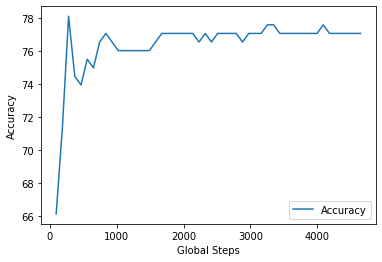

In [ ]:
plt.plot(global_steps_list, valid_accuracy_list, label='Accuracy')
plt.xlabel('Global Steps')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
def evaluate(model, test_loader):
  y_pred = []
  y_true = []

  model.eval()
  with torch.no_grad():
    for text, label in test_loader:
        encoded_list = [tokenizer.encode(t, add_special_tokens=True, max_length=300) for t in text]
        padded_list =  [e + [0] * (300-len(e)) for e in encoded_list]
    
        sample = torch.tensor(padded_list)
        labels = label
        sample, labels = sample.to(device), labels.to(device)
        output = model(sample, labels=labels)
        output = output.logits

        y_pred.extend(torch.argmax(F.softmax(output), dim=1).tolist())
        y_true.extend(labels.tolist())

  print('Classification 결과: ')
  print(classification_report(y_true, y_pred,
                              target_names=['SCZ_group', 'Mood_dz_group', 'Drug_abuse_group', 'Dementia_group', 'Developmental_dz_group', 'Others'],
                              digits=4))
  y_pred_SCZ = [x if x == 0 else 1 for x in y_pred]
  y_true_SCZ = [x if x == 0 else 1 for x in y_true]

  cm = confusion_matrix(y_true_SCZ, y_pred_SCZ, labels=[1,0])
  ax = plt.subplot()
  sns.heatmap(cm, annot=True, ax=ax, cmap='Blues', fmt="d")

  ax.set_title('Confusion Matrix')
  ax.set_xlabel('Predicted Labels')
  ax.set_ylabel('True Labels')
  ax.xaxis.set_ticklabels(['0', '1'])
  ax.yaxis.set_ticklabels(['0', '1'])

Model loaded from <== ./checkpoint/model.pt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Classification 결과: 
                        precision    recall  f1-score   support

             SCZ_group     0.7955    0.8974    0.8434       117
         Mood_dz_group     0.6296    0.5152    0.5667        33
      Drug_abuse_group     0.8571    0.9474    0.9000        57
        Dementia_group     0.7500    0.4286    0.5455         7
Developmental_dz_group     0.7143    0.3571    0.4762        14
                Others     0.0000    0.0000    0.0000         5

              accuracy                         0.7897       233
             macro avg     0.6244    0.5243    0.5553       233
          weighted avg     0.7637    0.7897    0.7689       233



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


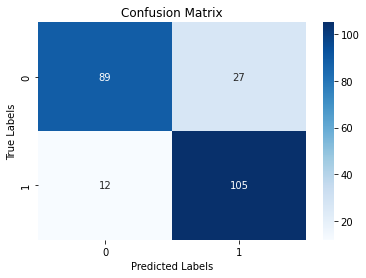

In [ ]:
best_model = model.to(device)
load_checkpoint('./checkpoint/model.pt', best_model)
evaluate(best_model, test_loader)

In [ ]:
sample = '환자는 독신, 부동산 중개업을 하며 주 3~5회 가량 소주 1~2병 음주 하였으나 이로인해 사회적 직업적 기능 저하는 두드러지지 않았다고 함. 내원 2년 전 환자는 쓰러진 채로 발견되었고 당시 뇌출혈 진단받았으나 수술할 정도는 아니었으며, 약물치료 및 경과관찰 하였으며 이후 경도의 구음장애, 사지 불편감이 있었다고 함. 환자는 일정한 거주지 없이 여관에서 혼자 살고 있으며 때때로 여동생이 와서 돌봐준다고 함. 하지만 이후 환자는 판단력 및 기억력이 떨어지고, 개인위생 챙기는 것도 불량하고 매일 소주 1병이상 먹으면서 일상생활에 문제가 생겼다고 함. 환자가 술만 먹다가 기력이 없어 누워있으면 여관주인이 보호자에게 전화를 주면 내과 병원 잠깐 입원 치료 받고 퇴원하는 양상 반복 하였다 함. 환자는 내원 2주전에도 general weakness로 횡성 대성 병원에 입원해 3일 후 불안, 불면, 갈망 등의 금담증상이 나타 나 환자가 자의적으로 탈원하여 그냥 집으로 와서 퇴원했다함. 이로 인'
sample = tokenizer.encode(sample[:300], add_special_tokens=True, max_length=300)
sample = [sample + [0]*(300-len(sample))]
sample = torch.tensor(sample)
label = torch.tensor(0)
sample, label = sample.to(device), label.to(device)

logits = model(sample).logits
torch.argmax(logits, 1).detach().cpu().tolist()

# sample = tokenizer.encode(sample[:300], add_special_tokens=True, max_length=300)
# sample = torch.tensor(sample)
# label = 0
# model(sample, labels=label)

[2]

In [ ]:
samples = ['상기 25세 환자는 어렸을 적 문제 없었으나 1년 전 군복무 이후 대인관계에 어려움을 겪으며 혼잣말 반복하는 모습을 보임.\n약 1달 전부터는 외부활동 극도로 줄어들며 환청, 환시 증상 심해지는 모습 보이며 \n가족들에게 공격적인 태도 악화되어 치료받기 위해 외래 통해서 내원하였음.',
           '본 60세 환자는 건설회사에 다니다가 1년 전 퇴직하였으며 약 20세 부터 음주 시작하였으며 주 2~3회 소주 2병 정도 음주하였음. \n약 2년 전 회사에서 퇴직하며 부인과의 관계가 악화되며 음주 습관 악화되었으며 6개월 전 배우자와 이별한 후 거의 매일 폭음하는 모습을 보임. \n최근에는 집에서 아들과 딸에게 폭언, 폭행 반복되는 모습 보이고 음주 양상 악화되는 추세로 치료를 위해 입원함.',
           '상기 15세 남환 초등학교 시절부터 지능 저하 있었으며 학교에서 왕따 문제 반복되어 내원하였음.',
           '상기 환자 약 6개월 전부터 정신과 진료 받던 분이며, 최근에 배우자와 갈등이 심해지고 경제적 어려움을 겪으면서 우울감 심해졌다고 함. \n약 1주 전 우울감 심해지며 손목을 긋는 등 자해행동 관찰되어 자녀들이 발견하고 치료 위해 입원하였음.',
           '상기 80세 환자 최근 심해진 인지기능 저하로 내원하였음. 약 2년 전부터 대화 도중 내용을 깜빡하는 일이 생기기 시작하였으며 \n최근에는 집 근처에서 혼자 산책하다가 길을 잃어버리거나 주변 사람들에게 예전에 사망한 남편이 살아있다는 이야기를 하는 모습을 보임. \n최근 인지기능 악화와 함게 일상생활에 어려움이 생겨 입원하기 위해 내원함.']


samples_encoding = [tokenizer.encode(t, add_special_tokens=True, max_length=300) for t in samples]
samples_padding = [t + [0]*(300-len(t)) for t in samples_encoding]
input = torch.tensor(samples_padding)
labels = torch.tensor([0, 2, 4, 1, 3])
input, labels = input.to(device), labels.to(device)

logits = model(input).logits
pred = torch.argmax(logits, 1).detach().cpu().tolist()

index_to_label = ['SCZ_group', 'Mood_dz_group', 'Drug_abuse_group', 'Dementia_group', 'Developmental_dz_group', 'Others']

for i in range(len(samples)):
  print('=====================================================')
  print('입력 문장\n : %s' % samples[i])
  print('\n예측 진단\n : %s' % index_to_label[pred[i]])


입력 문장
 : 상기 25세 환자는 어렸을 적 문제 없었으나 1년 전 군복무 이후 대인관계에 어려움을 겪으며 혼잣말 반복하는 모습을 보임.
약 1달 전부터는 외부활동 극도로 줄어들며 환청, 환시 증상 심해지는 모습 보이며 
가족들에게 공격적인 태도 악화되어 치료받기 위해 외래 통해서 내원하였음.

예측 진단
 : SCZ_group
입력 문장
 : 본 60세 환자는 건설회사에 다니다가 1년 전 퇴직하였으며 약 20세 부터 음주 시작하였으며 주 2~3회 소주 2병 정도 음주하였음. 
약 2년 전 회사에서 퇴직하며 부인과의 관계가 악화되며 음주 습관 악화되었으며 6개월 전 배우자와 이별한 후 거의 매일 폭음하는 모습을 보임. 
최근에는 집에서 아들과 딸에게 폭언, 폭행 반복되는 모습 보이고 음주 양상 악화되는 추세로 치료를 위해 입원함.

예측 진단
 : Drug_abuse_group
입력 문장
 : 상기 15세 남환 초등학교 시절부터 지능 저하 있었으며 학교에서 왕따 문제 반복되어 내원하였음.

예측 진단
 : Developmental_dz_group
입력 문장
 : 상기 환자 약 6개월 전부터 정신과 진료 받던 분이며, 최근에 배우자와 갈등이 심해지고 경제적 어려움을 겪으면서 우울감 심해졌다고 함. 
약 1주 전 우울감 심해지며 손목을 긋는 등 자해행동 관찰되어 자녀들이 발견하고 치료 위해 입원하였음.

예측 진단
 : Mood_dz_group
입력 문장
 : 상기 80세 환자 최근 심해진 인지기능 저하로 내원하였음. 약 2년 전부터 대화 도중 내용을 깜빡하는 일이 생기기 시작하였으며 
최근에는 집 근처에서 혼자 산책하다가 길을 잃어버리거나 주변 사람들에게 예전에 사망한 남편이 살아있다는 이야기를 하는 모습을 보임. 
최근 인지기능 악화와 함게 일상생활에 어려움이 생겨 입원하기 위해 내원함.

예측 진단
 : Dementia_group
